# Evaluating Environmental Impact of the Current Exam Portfolio

This notebook evaluates the environmental impact of the code from the previous four assignments in the current portfolio exam. The impact is measured in terms of CO₂ emissions, expressed as kilograms of CO₂-equivalent (CO₂eq).

## Import Packages

To install the necessary packages, first execute the 'setup.sh' script in the terminal:

```bash
$ source setup.sh
```

Afterwards, the packages can be imported:

In [2]:
import pandas as pd
import os
import glob
import seaborn as sns
import seaborn.objects as so
import matplotlib.pyplot as plt

## Load Data

CodeCarbon was implemented in all assignments in this portfolio exam to measure the environmental impact of the code. The data is stored in the ```out``` folder.

Each .csv file starting with 'emissions_base_' will be imported and the subtask-specific emission files will be combined into one dataframe. The dataframe will be filtered to include:

- project_name: the name of the given assignment
- task_name: specifying the subtasks
- duration: compute duration in seconds (s)
- emissions: approximate emissions in kg of CO₂eq
- emissions_rate: emissions per second (kg/s), multiplied by 10000 due to the small values

In [3]:
base_file_list = glob.glob(os.path.join("../out/emissions_base_*.csv"))

df = [pd.read_csv(file) for file in base_file_list]
df = pd.concat(df, ignore_index = True)

df.to_csv("../out/combined_base_emissions.csv", index = False)

df["emissions_rate"] = df["emissions_rate"] * 10000

df = df.loc[:, df.columns.isin(["project_name", "task_name", "duration", "emissions", "emissions_rate"])]
df.head()

,task_name,project_name,duration,emissions,emissions_rate
0,load and clean data,assignment 3,1.415629,1.442726e-05,0.102021
1,load model,assignment 3,13.662287,1.394071e-04,0.102080
2,expand query,assignment 3,1.683384,1.716881e-05,0.102058
3,calculate percentage,assignment 3,0.017760,1.762409e-07,0.100169
4,save results,assignment 3,0.005439,5.227045e-08,0.096755


## Data Wrangling

To identify the tasks that emit the most CO₂, all subtasks have been categorized into groups. The individual subtasks' 'task_name' will be mapped to their defined 'task_groups':


In [44]:
task_groups = {
    'load spacy model': 'Load Model',
    'load data, process text, and save results': 'Data Processing',
    'plot results': 'Plotting',
    'Load and split data': 'Data Wrangling',
    'Define vectorizer': 'Feature Extraction',
    'Fit vectorizer': 'Feature Extraction',
    'Load vectorized data': 'Data Wrangling',
    'Define classifier': 'Model Definition',
    'GridSearch': 'Hyperparameter Tuning',
    'Fit classifier': 'Model Training',
    'Evaluate classifier': 'Model Evaluation',
    'Plot loss curve': 'Plotting',
    'Permutation test': 'Permutation Testing',
    'Shap': 'Model Interpretation',
    'load and clean data': 'Data Wrangling',
    'load model': 'Load Model',
    'expand query': 'Data Processing',
    'calculate percentage': 'Data Processing',
    'save results': 'Saving Results',
    'visualise query': 'Plotting',
    'load classifier': 'Load Model',
    'predict emotion': 'Model Prediction',
    'reshape data': 'Data Wrangling',
    'plot season': 'Plotting',
    'plot emotion': 'Plotting',
}

df["task_group"] = df["task_name"].map(task_groups)


Total emission per assignment are calculated:

In [45]:
total_emission_per_project = df.groupby("project_name")["emissions"].sum().reset_index()
total_emission_per_project

,project_name,emissions
0,assignment 1,0.002422
1,assignment 2,0.009988
2,assignment 3,0.000193
3,assignment 4,0.022747


Finally, each subtask in all assignment's percentage contribution to the total emission will be calculated. The data is then pivoted, where each row represents a assignment and the columns are 'task_groups'. The values in the dataframe are the sum of the emission percentages for the given task group within each assignment. If a task group is not present in a project, its value is filled with 0.

In [46]:
df["total_emissions"] = df.groupby("project_name")["emissions"].transform("sum")
df["emission_percentage"] = df["emissions"] / df["total_emissions"] * 100
pivot_df = df.pivot_table(index = "project_name", columns = "task_group", values = "emission_percentage",
                            aggfunc = "sum", fill_value = 0)
pivot_df

task_group,Data Processing,Data Wrangling,Feature Extraction,Hyperparameter Tuning,Load Model,Model Definition,Model Evaluation,Model Interpretation,Model Prediction,Model Training,Permutation Testing,Plotting,Saving Results
project_name,,,,,,,,,,,,,
assignment 1,98.681542,0.000000,0.000000,0.000000,0.837669,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.480789,0.000000
assignment 2,0.000000,0.051997,1.346198,49.020008,0.000000,0.000276,0.034159,0.145254,0.000000,20.533975,28.830547,0.037585,0.000000
assignment 3,8.997655,7.484068,0.000000,0.000000,72.316747,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.174415,0.027115
assignment 4,0.000000,0.001328,0.000000,0.000000,0.244616,0.000000,0.000000,0.000000,99.628096,0.000000,0.000000,0.122511,0.003449


## Visualizations

### Total Emission per Assignment

To demonstrate the total CO₂eq emissions across assignments, the emissions from individual subtasks are summed.

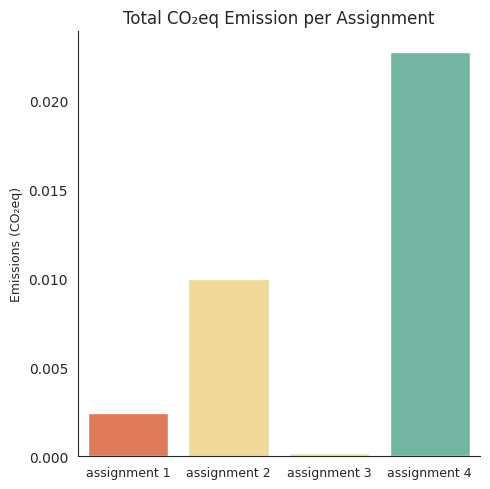

In [47]:
sns.set_style("white")

g = sns.catplot(total_emission_per_project, x = "project_name", y = "emissions",
                hue = "project_name", kind = "bar", palette = "Spectral")
plt.title("Total CO₂eq Emission per Assignment")
g.set_axis_labels("", "Emissions (CO₂eq)", fontsize = 9)
g.set_xticklabels(fontsize = 9)
plt.tight_layout()
plt.savefig("../plots/Emissions_per_Assignment.png")
plt.show()

### Task Emissions across Assignments

The following plot illustrates the percentage contribution of each subtask to the total emissions across the assignment. The subtask emissions are expressed as a percentage of the total CO₂eq emissions across assignments.

/tmp/ipykernel_33080/1019818436.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize = 9)


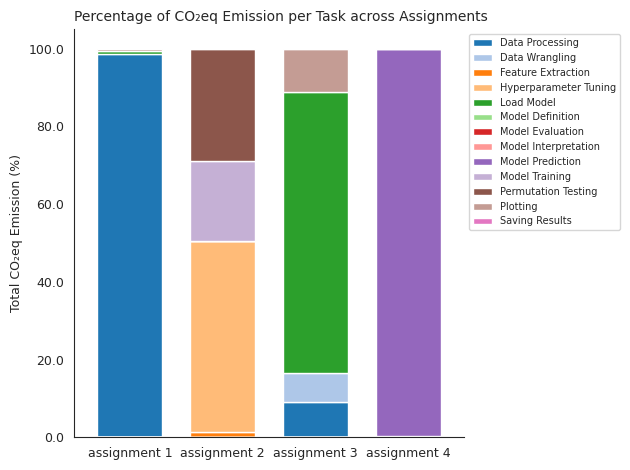

In [50]:
sns.set_style("white")

ax = pivot_df.plot(kind = 'bar', stacked = True, color = sns.color_palette("tab20", n_colors = 13), width = 0.7)

ax.set_title("Percentage of CO₂eq Emission per Task across Assignments", fontsize = 10, loc = "left")
ax.set_ylabel("Total CO₂eq Emission (%)", fontsize = 9)

legend = ax.legend(bbox_to_anchor=(1, 1), loc = "upper left", fontsize = 7)
legend.get_frame().set_linewidth(1)

ax.set_xlabel("")

ax.set_xticklabels(ax.get_xticklabels(), rotation = 0, ha = "center", fontsize = 9)
ax.set_yticklabels(ax.get_yticks(), fontsize = 9)

sns.despine()
plt.tight_layout()
plt.savefig("../plots/Subtask_Emissions_across_Assignments.png")
plt.show()

### Emission Distribution by Subtasks

Furthermore, the total emission by subtaks in percentage are illustrated:

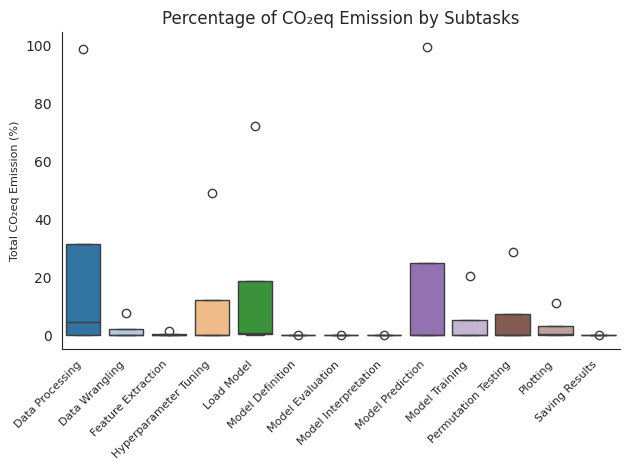

In [49]:
df_melted = pivot_df.reset_index().melt(id_vars = "project_name", var_name = "task_group", value_name = "emission_percentage")

sns.set_style("white")

sns.boxplot(x = "task_group", y = "emission_percentage", data = df_melted, hue = "task_group", palette = "tab20")
plt.title("Percentage of CO₂eq Emission by Subtasks", fontsize = 12)
plt.xlabel("")

plt.ylabel("Total CO₂eq Emission (%)", fontsize = 8)
plt.xticks(rotation = 45, ha = "right", fontsize = 8)

sns.despine()
plt.tight_layout()
plt.savefig("../plots/Emissions_per_Subtask.png")
plt.show()

### Emission for ML pipelines

Finally, the emissions of the two pipelines in assignment 2 are visualized:

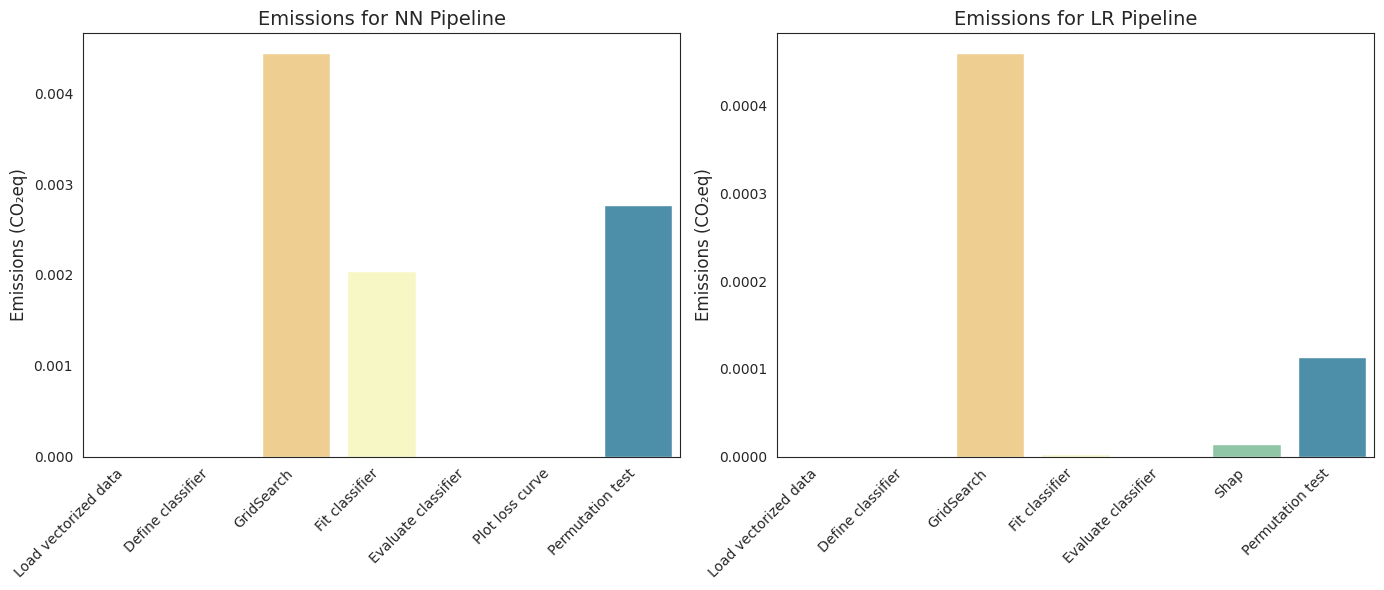

In [51]:
nn_indices = [3, 4, 5, 6, 7, 8, 9]
nn_df = assignment_2_df.iloc[nn_indices]

lr_indices = [10, 11, 12, 13, 14, 15, 16]
lr_df = assignment_2_df.iloc[lr_indices]

plt.figure(figsize = (14, 6))

plt.subplot(1, 2, 1)
sns.barplot(nn_df, x = "task_name", y = "emissions", hue = "task_name", palette = "Spectral")
plt.title("Emissions for NN Pipeline", fontsize = 14)
plt.xlabel("")
plt.ylabel("Emissions (CO₂eq)", fontsize = 12)
plt.xticks(rotation = 45, ha = "right", fontsize = 10)

plt.subplot(1, 2, 2)
sns.barplot(lr_df, x = "task_name", y = "emissions", hue = "task_name", palette = "Spectral")
plt.title("Emissions for LR Pipeline", fontsize = 14)
plt.xlabel("")
plt.ylabel("Emissions (CO₂eq)", fontsize = 12)
plt.xticks(rotation = 45, ha = "right", fontsize = 10)

plt.tight_layout()
plt.savefig("../plots/Emissions_per_pipeline_a2.png")
plt.show()